In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
from time import time

import mne
from mne.datasets import sample
from mne.preprocessing import ICA

print(__doc__)
data_dir = 'data_meg'
subj = "R2490"
dataqual = 'prepro' #or loc/exp
exp = 'exp' #or exp
dtype = "raw"
label_dir = 'data_log'
save_dir = 'data_meg'
raw_path = f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif'
bad_channels_dict = {
    "R2490": ['MEG 014', 'MEG 004', 'MEG 079', 'MEG 072', 'MEG 070', 'MEG 080', 'MEG 074', 'MEG 067', 'MEG 082', 'MEG 105', 'MEG 115', 'MEG 141', 'MEG 153'],
    "R2488": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 146', 'MEG 147', 'MEG 007', 'MEG 141'],
    "R2487": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 147', 'MEG 146', 'MEG 004'],
    "R2280": ['MEG 024', 'MEG 039', 'MEG 079', 'MEG 077', 'MEG 141', 'MEG 073', 'MEG 075', 'MEG 076', 'MEG 064', 'MEG 063', 'MEG 060', 'MEG 059', 'MEG 058']
}
bad_channels = bad_channels_dict.get(subj, [])
# raw_empty_room = mne.io.read_raw_fif(f'{data_dir}/{subj}/emptyroom/{subj}_emptyroom-{dtype}.fif', preload=True)
# raw_empty_room.info['bads'].extend(bad_channels)

Automatically created module for IPython interactive environment


In [2]:
# raw = mne.io.read_raw_fif('data_meg/R2490/prepro/R2490_exp.fif', preload='temp_raw.fif')
raw = mne.io.read_raw_fif(raw_path).load_data()
reject = dict(mag=5e-12, grad=4000e-13)
raw.info['bads'].extend(bad_channels)
sfreq = raw.info['sfreq']
raw.filter(1, 30, method='iir')
downsample = 10
raw.resample(sfreq / downsample)

Opening raw data file data_meg/R2490/prepro/R2490_exp.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_12376/3923839980.py:2: RuntimeWarning: This filename (data_meg/R2490/prepro/R2490_exp.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_path).load_data()


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2490/prepro/R2490_exp-1.fif...
    Range : 2780000 ... 3669999 =   2780.000 ...  3669.999 secs
Ready.
Reading 0 ... 3669999  =      0.000 ...  3669.999 secs...
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

4032 events found on stim channel STI 014
Event IDs: [160 161 162 163 164 166]
4032 events found on stim channel STI 014
Event IDs: [160 161 162 163 164 166]


<Raw | R2490_exp.fif, 193 x 367000 (3670.0 s), ~542.0 MB, data loaded>

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


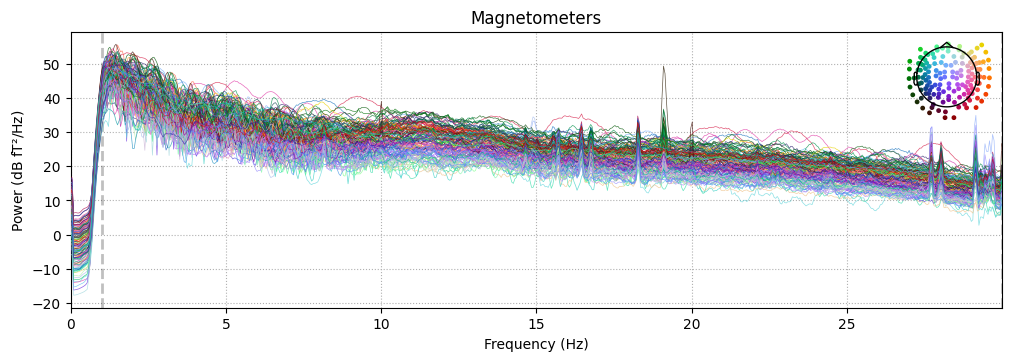

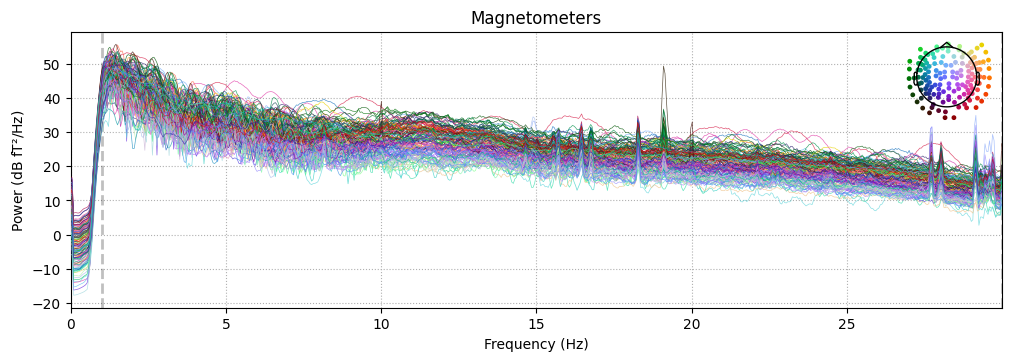

In [3]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)

In [4]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

# Define trials to remove
trials_to_remove = []
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
timeout_events = events[events[:, 2] == event_id['timeout']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']  # Sampling frequency

# Combine 'done' and 'timeout' events
end_events = np.concatenate((done_events, timeout_events))
end_events = end_events[end_events[:, 0].argsort()] 

4032 events found on stim channel STI 014
Event IDs: [160 161 162 163 164 166]


In [5]:
# Initialize a list to store trial information
trial_info = []
previous_start_sample = None
processed_starts = set()
start_idx = 0
trail_t = 25
# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    
    # Find the next end event after the start event
    end_idx = np.searchsorted(end_events[:, 0], start_sample, side='right')
    end_sample = None
    while end_idx < len(end_events):
        potential_end_sample = end_events[end_idx, 0]
        if (potential_end_sample - start_sample) / sfreq <= trail_t:
            end_sample = potential_end_sample
            break
        end_idx += 1

    # If no valid end event is found, set end_sample to 26 seconds after start_sample
    if end_sample is None:
        end_sample = start_sample + int(trail_t * sfreq)
        

    # Check if the current start is at least 20 seconds after the previous start
    if (previous_start_sample is None or (start_sample - previous_start_sample) / sfreq >= 20) and start_sample not in processed_starts:
        # Proceed with processing this start event
        previous_start_sample = start_sample
        processed_starts.add(start_sample)  # Add to the set of processed starts

        # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = trail_t  # Duration from 'start' to 1 s after end event
        reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                    (reveal_red_events[:, 0] < end_sample)]
        reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                        (reveal_white_events[:, 0] < end_sample)]
        # Store trial information, including whether 'reveal_red' and 'reveal_white' occurred
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': start_idx,
            'duration': tmax,
            'tmin': tmin,
            'tmax': trail_t,
            'done': len(done_events) > 0,
            'start_times': start_sample / sfreq,
            'done_times': end_sample / sfreq,
            'end_sample': end_sample,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            )
        })
        start_idx += 1

In [6]:
# Print the range of `done_times`
print(f"Done times range: {min([info['done_times'] for info in trial_info])}, {max([info['done_times'] for info in trial_info])}")
print(f"Raw data duration: {raw.times[0]} to {raw.times[-1]} seconds")


Done times range: 99.82, 3655.66
Raw data duration: 0.0 to 3669.99 seconds


In [7]:
epochs_data_list = []
trial_info_valid = []

for idx, event in enumerate(start_events):
    tmin = -0.2
    tmax = trail_t
    start_sample = event[0]
    event_id_code = event[2]
    end_sample = trial_info[idx]['end_sample']
    total_duration = raw.times[-1]
    print(f"Tmax is {tmax}")
    # Create the epoch
    picks = mne.pick_types(raw.info, meg=True, exclude='bads')
    epochs = mne.Epochs(
        raw, [event], event_id={f'event_{event_id_code}': event_id_code},
        tmin=tmin, tmax=tmax, preload=True,
        reject_by_annotation=False, reject=None, verbose=True, picks=picks
    )
    
    if len(epochs) > 0:
        epochs_data_list.append(epochs.get_data())
        trial_info_valid.append(trial_info[idx])
    else:
        print(f"Epoch {idx} was dropped.")
        print(f"Drop log for Epoch {idx}: {epochs.drop_log}")


Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 2521 original time points ...
0 bad epochs dropped
Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 2521 original time points ...
0 bad epochs dropped
Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 2521 original time points ...
0 bad epochs dropped
Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded 

## Decoding

In [8]:
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score


In [15]:
def augment_with_sliding_vectors(X, shifts):
    """
    Augments the data by creating shifted versions of the time points.

    Parameters:
    - X: ndarray of shape (n_epochs, n_channels, n_time_points)
    - shifts: list of integers, number of time points to shift (positive or negative).

    Returns:
    - X_augmented: ndarray of shape (n_augmented_epochs, n_channels, n_time_points)
    """
    X_augmented = []
    for shift in shifts:
        if shift > 0:
            # Shift forward
            X_shifted = np.pad(X[:, :, :-shift], ((0, 0), (0, 0), (shift, 0)), mode='constant')
        elif shift < 0:
            # Shift backward
            X_shifted = np.pad(X[:, :, -shift:], ((0, 0), (0, 0), (0, -shift)), mode='constant')
        else:
            # No shift
            X_shifted = X
        X_augmented.append(X_shifted)

    return np.concatenate(X_augmented, axis=0)




def train_time_decoder(X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='roc_auc')
    scores = cross_val_multiscore(time_decoding, X, y, cv=cv, n_jobs=5)
    print(f"Scores shape: {scores.shape}")
    scores_mean = np.mean(scores, axis=0)
    return scores_mean


# Function to perform time decoding and plot results for two sets of trials
def plot_time_decoding(scores_mean,title, subj):
    n_time_points = scores_mean.shape[0]
    # scores_mean = smooth_scores(scores_mean)
    plt.plot(np.arange(n_time_points), scores_mean)
    plt.xlim(0, 400)
    plt.axhline(1/n_classes, color='k', linestyle='--', label='chance')
    plt.xlabel('Time Points')
    plt.ylabel('Accuracy')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'output/{subj}_time_decoding_{n_time_points}.png')

In [18]:
# Convert the filtered epochs data to a numpy array
X = np.array([md.data for md in epochs_data_list])  # Shape: (n_epochs, n_channels, n_times)
X = X.squeeze(axis=1)

labels_df = pd.read_csv(f'data_log/{subj}/label.csv')
# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info_valid}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]

# Create a mapping from trial_index to label using the filtered labels_df
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info_valid:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

# Convert labels to integers using label encoder
y_labels = label_encoder.fit_transform(y_labels)
shifts = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

# Augment data with surrounding time points
X_augmented = augment_with_sliding_vectors(X, shifts)

# Duplicate labels for augmented data
y_augmented = np.tile(y_labels, len(shifts))

print(f"Original X shape: {X.shape}, Augmented X shape: {X_augmented.shape}")
print(f"Original y shape: {y_labels.shape}, Augmented y shape: {y_augmented.shape}")


X shape: (120, 144, 2521)
Original X shape: (120, 144, 2521), Augmented X shape: (1320, 144, 2521)
Original y shape: (120,), Augmented y shape: (1320,)


In [19]:
scores_augmented_mean = train_time_decoder(X_augmented, y_augmented)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  2%|▏         | Fitting SlidingEstimator : 42/2521 [03:14<2:10:05,    3.15s/it]
  2%|▏         | Fitting SlidingEstimator : 47/2521 [03:31<2:10:29,    3.16s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
python(14430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  2%|▏         | Fitting SlidingEstimator : 59/2521 [04:23<2:29:00,    3.63s/it]
  2%|▏         | Fitting SlidingEstimator : 60/2521 [04:24<2:23:05,    3.49s/it]
  2%|▏         | Fitting SlidingEstimator : 61/2521 [04:24<2:16:26,    3.33s/it]
  0%|          | Fitting SlidingEstimator : 3/2521 

KeyboardInterrupt: 

In [9]:
def extract_reveal(trial_info_valid, raw, label_dict, event_name='reveal_red', n_points_before=50, n_points_after=50, num_events=2):
    y_labels = []
    X_reveal = []
    trial_indices = []
    sfreq = raw.info['sfreq']  # Sampling frequency

    for info in trial_info_valid:
        reveal_times = info[f'{event_name}_times']
        if len(reveal_times) >= num_events:
            trial_data = []

            for event_time in reveal_times[:num_events]:
                event_sample = int(event_time * sfreq)
                start_sample_before = event_sample - n_points_before
                end_sample_after = event_sample + n_points_after

                if start_sample_before >= 0 and end_sample_after <= raw.n_times:
                    picks = mne.pick_types(raw.info, meg=True, exclude='bads')
                    epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after,picks=picks)
                
                    # Ensure epoch_data is 3D
                    if epoch_data.ndim == 2:
                        epoch_data = np.expand_dims(epoch_data, axis=2)
                    
                    trial_data.append(epoch_data)

            if trial_data:
                # Check if all trial_data have the same shape
                trial_data_shapes = [data.shape for data in trial_data]
                if len(set(trial_data_shapes)) == 1:
                    trial_data_concatenated = np.concatenate(trial_data, axis=2)
                    X_reveal.append(trial_data_concatenated)
                    trial_index = info['trial_index']
                    if trial_index in label_dict:
                        y_labels.append(label_dict[trial_index])
                        trial_indices.append(trial_index)
                else:
                    print(f"Inconsistent shapes in trial data for trial index {info['trial_index']}: {trial_data_shapes}")

    return np.array(X_reveal), np.array(y_labels), trial_indices

def extract_start(trial_info, raw, label_dict, n_points_before=50, n_points_after=50):
    X_start = []
    y_labels = []
    trial_indices = []
    for info in trial_info:
        # Get the done sample from the trial information
        start_sample = info['event_sample'] + int((info['tmin'] + 0.2) * raw.info['sfreq'])

        # Calculate start and end samples for extraction
        start_sample_before = start_sample - n_points_before
        end_sample_after = start_sample + n_points_after

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            # Extract data for this trial
            picks = mne.pick_types(raw.info, meg=True, exclude='bads')
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after,picks=picks)
                
            X_start.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return  np.array(X_start), np.array(y_labels), trial_indices


def extract_done(trial_info, raw, label_dict, n_points_before=50, n_points_after=50):
    X_done = []
    y_labels = []
    trial_indices = []
    sfreq = raw.info['sfreq']  # Sampling frequency
    done_times = [info['done_times'] for info in trial_info]
    start_times = [info['start_times'] for info in trial_info]
    
    for info, done_time, start_time in zip(trial_info, done_times, start_times):
        # Check if the "done" event exists
        done_time = info['done_times'] 
        start_time = info['start_times']
        print(f"Trial_index: {info['trial_index']}, Done time: {done_time}, Start time: {start_time}")
        if int(done_time) - int(start_time) > 25:  # Assuming these indicate the presence of a "done" event
            done_sample = info['event_sample'] + int((info['tmax'] - 1.0) * sfreq)
            start_sample_before = done_sample - n_points_before
            end_sample_after = done_sample + n_points_after
        else:
            start_sample_before = int(done_time * sfreq) - n_points_before
            end_sample_after = int(done_time * sfreq) + n_points_after

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            picks = mne.pick_types(raw.info, meg=True, exclude='bads')
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after,picks=picks)
                
            X_done.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return np.array(X_done), np.array(y_labels), trial_indices


In [10]:
# Extract the first n_events reveal events
epoch_reveal, y_labels_reveal, trial_indices_reveal = extract_reveal(trial_info_valid, raw, label_dict, num_events=3)
epoch_start, y_labels_start, trial_indices_start = extract_start(trial_info_valid, raw, label_dict)
epoch_done, y_labels_done, trial_indices_done = extract_done(trial_info_valid, raw, label_dict)

# Find common trial indices across all epochs
common_trial_indices = set(trial_indices_reveal) & set(trial_indices_start) & set(trial_indices_done)

# Convert to a sorted list to maintain order
common_trial_indices = sorted(common_trial_indices)

# Function to filter epochs and labels based on common trial indices
def filter_by_trial_indices(epochs, labels, trial_indices, common_indices):
    mask = [i for i, idx in enumerate(trial_indices) if idx in common_indices]
    return epochs[mask], labels[mask]

# Filter each epoch and labels
epoch_start_filtered, y_labels_start_filtered = filter_by_trial_indices(epoch_start, y_labels_start, trial_indices_start, common_trial_indices)
epoch_reveal_filtered, y_labels_reveal_filtered = filter_by_trial_indices(epoch_reveal, y_labels_reveal, trial_indices_reveal, common_trial_indices)
epoch_done_filtered, y_labels_done_filtered = filter_by_trial_indices(epoch_done, y_labels_done, trial_indices_done, common_trial_indices)

# Flatten the reveal epoch to combine the event dimension into the time axis
n_trials, n_channels, n_timepoints_per_event, n_events = epoch_reveal_filtered.shape
epoch_reveal_flattened = epoch_reveal_filtered.reshape(n_trials, n_channels, n_timepoints_per_event * n_events)

# Check the new shape
print(f"Flattened epoch_reveal shape: {epoch_reveal_flattened.shape}")

# Combine the filtered epochs
X_combined = np.concatenate((epoch_start_filtered, epoch_reveal_flattened, epoch_done_filtered), axis=2)
print(f"Combined data shape: {X_combined.shape}")

# Use the labels from the first filtered epoch (assuming they are the same for all)
y_combined = y_labels_done_filtered

# Check the shape of the labels
print(f"Labels shape: {y_combined.shape}")

Trial_index: 0, Done time: 99.82, Start time: 90.44
Trial_index: 1, Done time: 135.96, Start time: 116.11
Trial_index: 2, Done time: 159.33, Start time: 141.95
Trial_index: 3, Done time: 188.77, Start time: 167.77
Trial_index: 4, Done time: 218.9, Start time: 197.9
Trial_index: 5, Done time: 244.42, Start time: 227.98
Trial_index: 6, Done time: 274.78, Start time: 253.78
Trial_index: 7, Done time: 295.08, Start time: 279.93
Trial_index: 8, Done time: 326.72, Start time: 305.72
Trial_index: 9, Done time: 340.54, Start time: 335.79
Trial_index: 10, Done time: 382.37, Start time: 361.37
Trial_index: 11, Done time: 409.36, Start time: 391.49
Trial_index: 12, Done time: 442.03, Start time: 421.03
Trial_index: 13, Done time: 472.12, Start time: 451.12
Trial_index: 14, Done time: 482.6, Start time: 477.01
Trial_index: 15, Done time: 523.61, Start time: 502.61
Trial_index: 16, Done time: 541.16, Start time: 532.73
Trial_index: 17, Done time: 571.61, Start time: 558.38
Trial_index: 18, Done tim

# Cross-validation

In [11]:
print(f"y_combined: {y_combined}")

y_combined: ['tree' 'chain' 'loop' 'loop' 'loop' 'chain' 'chain' 'chain' 'loop' 'loop'
 'loop' 'chain' 'tree' 'chain' 'chain' 'tree' 'tree' 'chain' 'tree'
 'chain' 'tree' 'loop' 'chain' 'tree' 'tree' 'loop' 'loop' 'chain' 'loop'
 'chain' 'loop' 'loop' 'tree' 'tree' 'chain' 'chain' 'tree' 'chain' 'loop'
 'loop' 'tree' 'loop' 'loop' 'loop' 'loop' 'loop' 'tree' 'tree' 'tree'
 'loop' 'tree' 'tree' 'tree' 'chain' 'loop' 'tree' 'chain' 'chain' 'loop'
 'chain' 'tree' 'loop' 'loop' 'chain' 'chain' 'tree' 'tree' 'chain' 'loop'
 'chain' 'tree' 'loop' 'loop' 'loop' 'chain' 'loop' 'tree' 'chain' 'chain'
 'chain' 'tree' 'loop' 'chain' 'loop' 'loop' 'chain' 'tree' 'loop' 'tree'
 'tree' 'tree' 'chain' 'tree' 'chain' 'tree' 'tree' 'loop' 'chain' 'loop'
 'chain' 'tree' 'chain' 'tree' 'tree' 'tree' 'chain' 'loop' 'chain']


In [17]:
print(f"y_labels: {y_labels}")

y_labels: [2 0 1 1 1 0 0 0 1 1 1 0 2 0 0 2 2 0 2 0 2 1 0 2 2 1 1 0 1 0 1 1 2 2 0 0 2
 0 1 1 2 1 1 1 1 1 2 2 2 1 2 2 2 0 1 2 0 0 1 0 2 1 1 0 0 2 2 0 1 0 2 1 1 1
 0 1 2 0 0 0 2 1 0 1 1 0 2 1 2 2 2 0 2 0 2 2 1 0 1 0 2 0 2 2 2 0 1 0]


In [19]:
# # Convert the filtered epochs data to a numpy array
# X = np.array([md.data for md in epochs_data_list])  # Shape: (n_epochs, n_channels, n_times)
# X = X.squeeze(axis=1)
X = X_combined
y_labels = label_encoder.fit_transform(y_combined)
import numpy as np

# Assuming y_labels is already encoded to integers
# Filter indices where y_labels is 0 or 1
valid_indices = [i for i, label in enumerate(y_labels) if label in [2,1]]

# Filter X and y_labels using the valid indices
X_filtered = X[valid_indices]
y_labels_filtered = y_labels[valid_indices]

# # Print the shapes to verify
# print(f"Filtered X shape: {X_filtered.shape}")
# print(f"Filtered y_labels length: {len(y_labels_filtered)}")
# labels_df = pd.read_csv(f'data_log/{subj}/label.csv')
# # Step 1: Get the valid trial indices
# valid_trial_indices = {info['trial_index'] for info in trial_info_valid}

# # Step 2: Filter labels_df to only include valid trial indices
# labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]

# # Create a mapping from trial_index to label using the filtered labels_df
# label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# # Step 3: Extract labels for the valid trials in trial_info_valid
# y_labels = []
# for info in trial_info_valid:
#     idx = info['trial_index']
#     if idx in label_dict:
#         y_labels.append(label_dict[idx])

# # Convert labels to integers using label encoder
# y_labels = label_encoder.fit_transform(y_labels)

# # Print the number of labels and valid trials after matching
# n_labels = len(y_labels)
n_trials = len(trial_info_valid)
print(f"X_filtered shape: {X_filtered.shape}")
print(f"y_labels_filtered shape: {y_labels_filtered.shape}")
print(f"X shape: {X_filtered.shape}")
print(f"Info channels: {len(epochs.info['ch_names'])}")

X_filtered shape: (72, 144, 500)
y_labels_filtered shape: (72,)
X shape: (72, 144, 500)
Info channels: 144


In [20]:
import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X_filtered, y_labels_filtered, cv=5, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print(f"Spatio-temporal: {100 * score:0.1f}%")
# Initialize the SlidingEstimator with the pipeline
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="accuracy", verbose=True)

# Fit the model
time_decod.fit(X_filtered, y_labels_filtered)
scores = cross_val_multiscore(clf, X_filtered, y_labels_filtered, cv=5, n_jobs=None)



Spatio-temporal: 60.9%


100%|██████████| Fitting SlidingEstimator : 500/500 [00:26<00:00,   19.12it/s]


No projector specified for this dataset. Please consider the method self.add_proj.


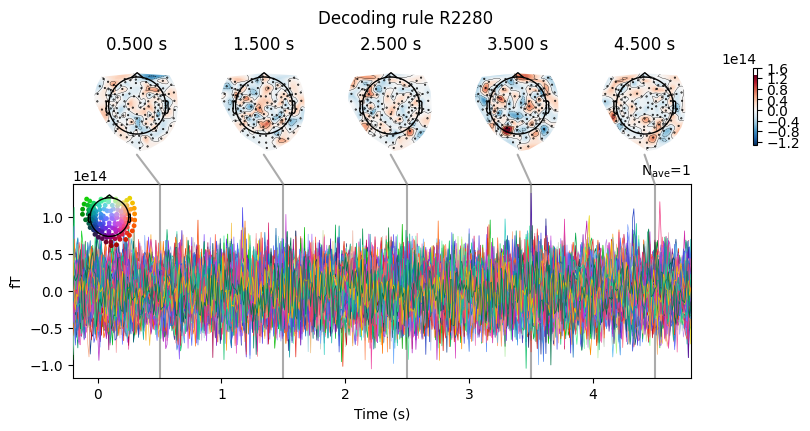

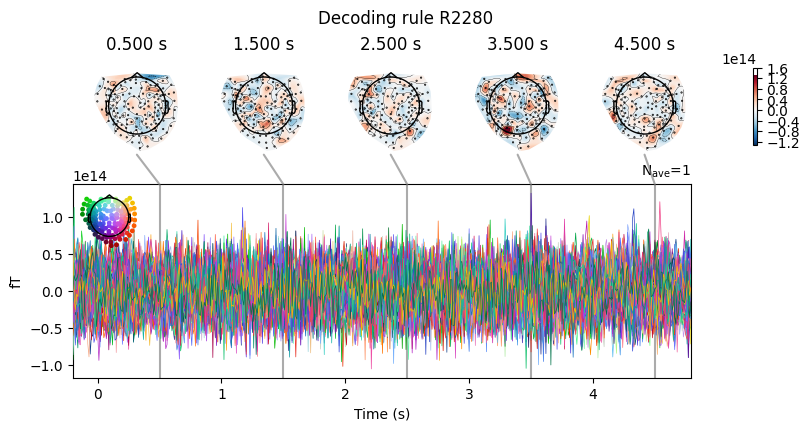

In [82]:
coef = np.array([est[-1].coef_ for est in time_decod.estimators_])
coef_2d = coef.squeeze(axis=1).T  # Remove the singleton dimension and transpose

# Create an EvokedArray for visualization
evoked_time_gen = mne.EvokedArray(coef_2d, epochs.info, tmin=epochs.times[0])

# Plot the results
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))
evoked_time_gen.plot_joint(
    times=np.arange(0.5, 5.5, 1), title=f"Decoding rule {subj}", **joint_kwargs
)


In [75]:

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from mne.decoding import SlidingEstimator, cross_val_multiscore 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_predict 
import seaborn as sns   


In [76]:
labels_df = pd.read_csv(f'data_log/{subj}/label.csv')
# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info_valid}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]

# Create a mapping from trial_index to label using the filtered labels_df
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info_valid:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

# Convert labels to integers using label encoder
y_label = label_encoder.fit_transform(y_labels)

# Print the number of labels and valid trials after matching
n_labels = len(y_labels)
n_trials = len(trial_info_valid)
print(f"Number of labels after matching: {n_labels}")
print(f"Number of valid trials after matching: {n_trials}")



Number of labels after matching: 120
Number of valid trials after matching: 120


In [28]:
from scipy.ndimage import gaussian_filter1d
def smooth_scores(scores, sigma=3):
    return gaussian_filter1d(scores, sigma=sigma)

In [22]:
from sklearn.model_selection import LeaveOneOut
n_time_points = X_filtered.shape[2]
n_classes = len(np.unique(y_labels_filtered))
n = len(X_filtered)
def smooth_scores(scores, sigma=2):
    return gaussian_filter1d(scores, sigma=sigma)

def train_time_decoder(X, y):
        # Train the time decoder on the entire dataset
    x_len = len(X)
    n_trials = len(y)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')

    scores = cross_val_multiscore(time_decoding, X, y, cv=cv, n_jobs=5)
    print(f"Scores shape: {scores.shape}")
    scores_mean = np.mean(scores, axis=0)
    return scores_mean


# Function to perform time decoding and plot results for two sets of trials
def plot_time_decoding(scores_mean,title, subj):
    n_time_points = scores_mean.shape[0]
    scores_mean = smooth_scores(scores_mean)
    plt.plot(np.arange(n_time_points), scores_mean)
    plt.xlim(0, 400)
    plt.axhline(1/n_classes, color='k', linestyle='--', label='chance')
    plt.xlabel('Time Points')
    plt.ylabel('Accuracy')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'output/{subj}_time_decoding_{n_time_points}.png')

In [83]:
# scores_mean_600ms = train_time_decoder(X_combined, y_combined)
# plot_time_decoding(scores_mean_600ms, 'Time Decoding 600ms', subj = subj)
# scores_mean_2500ms = train_time_decoder(X, y)
# plot_time_decoding(scores_mean_2500ms, 'Time Decoding 2500ms', subj = subj


In [103]:
def plot_time_decoding(scores_mean, title, subj, bin_size=10):
    # Calculate standard deviation
    scores_std = np.std(scores_mean)

    # Reshape and average every `bin_size` time points
    n_time_points = scores_mean.shape[0]
    n_bins = n_time_points // bin_size
    if n_bins == 0:
        print("Error: Not enough data points to create bins.")
        return

    binned_mean = scores_mean[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    binned_std = scores_std * np.ones_like(binned_mean)  # Use a constant std for simplicity
    
    # Plotting
    time_points = np.arange(n_bins) * bin_size
    
    plt.plot(time_points, binned_mean, label='Mean Accuracy')
    plt.fill_between(time_points, binned_mean - binned_std, binned_mean + binned_std, alpha=0.2, label='Variance')
    plt.ylim(0.2, 0.7)
    plt.xlim(250,450)
    plt.axhline(1/n_classes, color='k', linestyle='--', label='Chance')
    plt.axvline(50, color='k', linestyle='--')
    plt.xlabel('Time Points (binned)')
    plt.ylabel('Accuracy')
    plt.suptitle(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function with the scores_mean


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  1%|          | Fitting SlidingEstimator : 5/500 [00:00<00:10,   48.71it/s]
  2%|▏         | Fitting SlidingEstimator : 9/500 [00:00<00:09,   50.97it/s]
  2%|▏         | Fitting SlidingEstimator : 12/500 [00:00<00:09,   53.38it/s][A
  1%|          | Fitting SlidingEstimator : 4/500 [00:00<00:13,   38.07it/s]

  3%|▎         | Fitting SlidingEstimator : 13/500 [00:00<00:10,   48.17it/s]A
  3%|▎         | Fitting SlidingEstimator : 16/500 [00:00<00:09,   51.47it/s][A
  1%|▏         | Fitting SlidingEstimator : 7/500 [00:00<00:14,   35.12it/s]

  0%|          | Fitting SlidingEstimator : 1/500 [00:00<00:52,    9.53it/s]
  2%|▏         | Fitting SlidingEstimator : 9/500 [00:00<00:13,   35.14it/s]

  1%|          | Fitting SlidingEstimator : 4/500 [00:00<00:18,   26.61it/s]
  5%|▍         | Fitting SlidingEstimator : 23/500 [00:00<00:09,   50.79it/s]




  1%|          | Fitting SlidingEstimator : 5/500 [00:00<00:19

Scores shape: (5, 500)


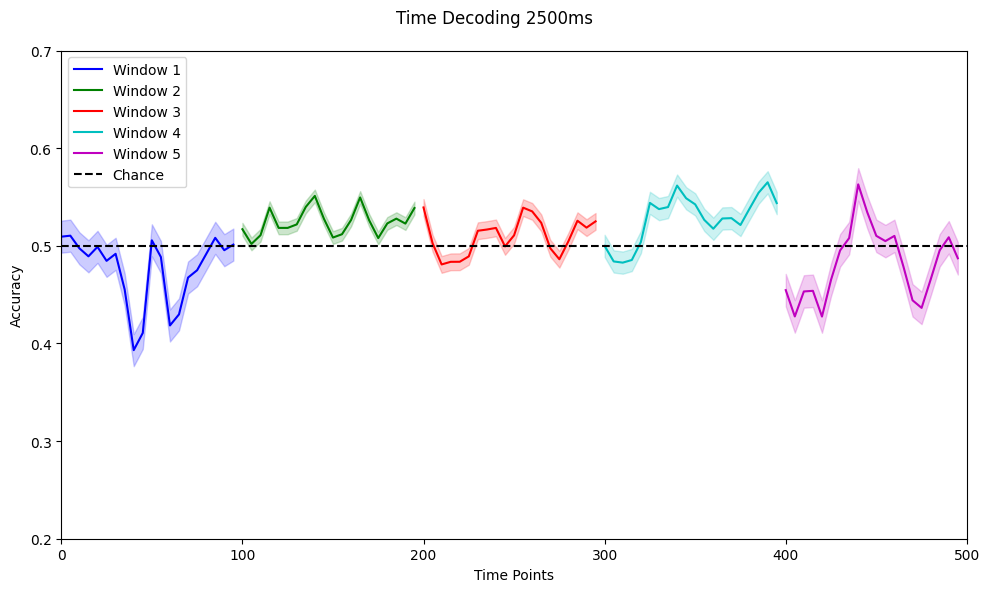

In [29]:
scores_mean = train_time_decoder(X_filtered, y_labels_filtered)



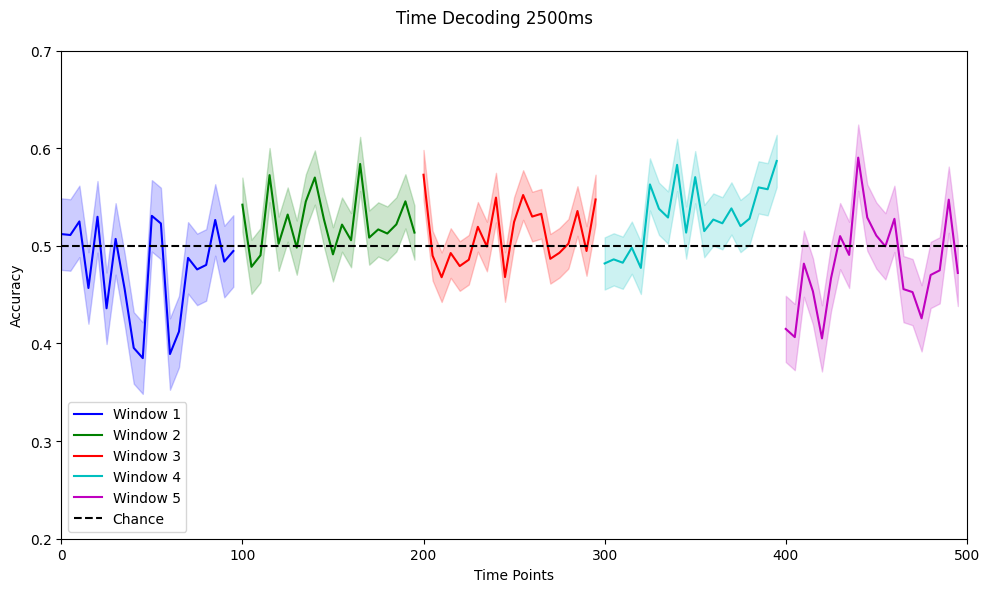

In [33]:
def plot_time_decoding(scores_mean, title, subj, window_size=100, bin_size=5):
    n_time_points = scores_mean.shape[0]
    n_windows = n_time_points // window_size
    # scores_mean = smooth_scores(scores_mean)
    # Check if there are enough data points
    if n_windows == 0:
        print("Error: Not enough data points to create windows.")
        return

    # Define colors for each window
    colors = ['b', 'g', 'r', 'c', 'm']  # Add more colors if needed

    plt.figure(figsize=(10, 6))
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        window_mean = scores_mean[start_idx:end_idx]
        
        # Bin the data within the window
        n_bins = window_size // bin_size
        if n_bins == 0:
            print("Error: Not enough data points to create bins within the window.")
            continue

        binned_mean = window_mean[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
        binned_std_error = np.std(window_mean) / np.sqrt(bin_size)  # Calculate standard error

        # Plotting
        time_points = np.arange(n_bins) * bin_size + start_idx
        plt.plot(time_points, binned_mean, label=f'Window {i+1}', color=colors[i % len(colors)])
        plt.fill_between(time_points, binned_mean - binned_std_error, binned_mean + binned_std_error, alpha=0.2, color=colors[i % len(colors)])

    plt.ylim(0.2, 0.7)
    plt.xlim(0, n_time_points)
    plt.axhline(1/len(np.unique(y_labels_filtered)), color='k', linestyle='--', label='Chance')
    plt.xlabel('Time Points')
    plt.ylabel('Accuracy')
    plt.suptitle(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_time_decoding(scores_mean, 'Time Decoding 2500ms', subj)